# Comparative Image Quality Analysis: Citizen Science vs. Research Grade Fossil Images

## Overview

This notebook performs an image quality comparison between two fossil image datasets:

- **OVC dataset** (Oervondstchecker): Citizen science images from `images_ovc/`
- **NBC dataset** (Naturalis): Research-grade museum images from `images_nbc/`

### Research Question

Do citizen science fossil images differ significantly in quality from professionally curated museum images? Understanding these differences can informm what feeback to give users to improve image quality.

### Analysis Pipeline

1. **Basic Statistics**: Image dimensions and aspect ratios
2. **Quality Metrics**: Seven complementary measures of image quality
3. **Visualization**: Distribution analysis and dataset clustering
4. **Statistical Testing**: Hypothesis testing for significant differences

## 1. Data Loading and Initial Exploration

I begin by loading images from both datasets and displaying representative examples to understand the visual characteristics of each source.

**Purpose**: Get a qualitative sense of how the two datasets differ visually before quantitative analysis.

In [2]:
# Imports
from PIL import Image
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np
import cv2
import piq
from PIL import Image
from scipy.fft import fftshift
from scipy.fftpack import fft2
import torchvision.transforms as T
from skimage import io
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy

OVC images found: 0
NBC images found: 0


IndexError: list index out of range

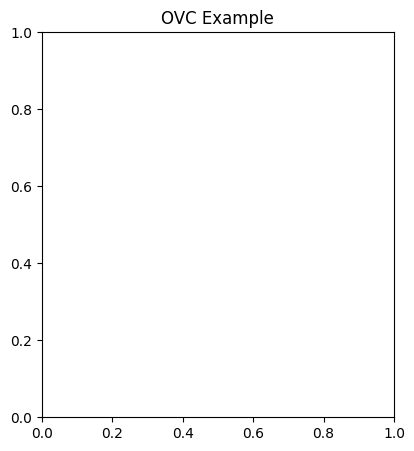

In [11]:
drive_folder = 'G:\Meine Ablage/' # Path to Google Drive folder
ovc_folder = 'G:\Meine Ablage\ALL_IMAGES_OVC.lnk'
nbc_folder = 'G:\Meine Ablage\PHOTOS_NBC.lnk'

ovc_images = sorted(glob(os.path.join(ovc_folder, '*')))
nbc_images = sorted(glob(os.path.join(nbc_folder, '*')))

print(f'OVC images found: {len(ovc_images)}')
print(f'NBC images found: {len(nbc_images)}')

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('OVC Example')
plt.imshow(Image.open(ovc_images[0]))
plt.axis('off')

plt.subplot(1,2,2)
plt.title('NBC Example')
plt.imshow(Image.open(nbc_images[0]))
plt.axis('off')
plt.show()

## 2. Basic Image Statistics

Before diving into quality metrics, I have a look at the fundamental image characteristics:
- **Width and Height**: Image resolution affects detail capture
- **Aspect Ratio**: Indicates compositional standards (e.g., square vs. rectangular framing)

These statistics help understand whether datasets differ in capture methodology or equipment.

**Why This Matters**: Resolution differences can affect the interpretation of quality metrics. For example, higher resolution images naturally have more detail and potentially higher sharpness scores.

In [ ]:
def get_basic_stats(img_list):
    widths, heights, aspect_ratios = [], [], []
    for path in img_list:
        try:
            img = Image.open(path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
            aspect_ratios.append(w / h if h != 0 else float('nan'))
        except Exception:
            widths.append(float('nan'))
            heights.append(float('nan'))
            aspect_ratios.append(float('nan'))
    return {
        "width": widths,
        "height": heights,
        "aspect_ratio": aspect_ratios
    }

ovc_stats = get_basic_stats(ovc_images)
nbc_stats = get_basic_stats(nbc_images)

print("OVC Image Stats:")
print(f"  Mean width: {np.nanmean(ovc_stats['width']):.1f}")
print(f"  Mean height: {np.nanmean(ovc_stats['height']):.1f}")
print(f"  Mean aspect ratio (w/h): {np.nanmean(ovc_stats['aspect_ratio']):.2f}")

print("\nNBC Image Stats:")
print(f"  Mean width: {np.nanmean(nbc_stats['width']):.1f}")
print(f"  Mean height: {np.nanmean(nbc_stats['height']):.1f}")
print(f"  Mean aspect ratio (w/h): {np.nanmean(nbc_stats['aspect_ratio']):.2f}")


## 3. Image Quality Metrics

We compute seven complementary quality metrics that capture different aspects of image quality. Each metric provides unique insights into how suitable images are for scientific analysis.

### 3.1 Quality Metrics: Definitions and Methodology

#### 1. **BRISQUE (Blind/Referenceless Image Spatial Quality Evaluator)**

- **What**: No-reference quality metric based on natural scene statistics
- **How**: Analyzes local normalized luminance coefficients to detect distortions (blur, noise, compression artifacts)
- **Interpretation**: Lower scores = better perceptual quality (typically 0-100 range)
- **Why**: Correlates well with human perception without needing reference images. This is crucial because we don't have "ground truth" perfect versions of these fossil images
- **Source**: [Mittal et al. (2012) - IEEE Transactions on Image Processing](https://live.ece.utexas.edu/research/Quality/index_algorithms.htm)

#### 2. **Laplacian Variance (Sharpness)**

- **What**: Measures image focus/blur using edge detection
- **How**: Applies Laplacian operator (2nd derivative) to detect edges, then computes variance of the result
- **Interpretation**: Higher values = sharper images with more defined edges
- **Why**: Critical for identifying fine details in fossil structures (e.g., shell ridges, bone texture)
- **Implementation**: `cv2.Laplacian(image, cv2.CV_64F).var()`
- **Caveat**: Very high values might indicate noise rather than true sharpness

#### 3. **FFT-based Sharpness**

- **What**: Frequency domain measure of high-frequency content
- **How**: Computes 2D Fast Fourier Transform and sums high-frequency components (edges and fine details)
- **Interpretation**: Higher values = more high-frequency detail (sharp edges, fine textures)
- **Why**: Complements spatial sharpness by analyzing frequency composition. Blurry images have mostly low frequencies
- **Note**: Excludes central 100×100 pixels which represent low frequencies (smooth gradients)

#### 4. **Shannon Entropy**

- **What**: Measures information content/complexity in bits
- **How**: Calculates entropy from grayscale intensity histogram: $H = -\sum p(i) \log_2 p(i)$ where $p(i)$ is the probability of intensity value $i$
- **Interpretation**: Higher values = more texture variation and detail. A blank image has entropy ≈ 0
- **Why**: Indicates richness of structural information. Higher entropy suggests more distinguishable features
- **Range**: Typically 0-8 bits for 8-bit grayscale images

#### 5. **Colorfulness**

- **What**: Quantifies color vividness and saturation
- **How**: Combines standard deviation and mean of RG and YB opponent color differences: $C = \sigma_{rgbb} + 0.3 \cdot \mu_{rgbb}$
- **Interpretation**: Higher values = more saturated, vibrant colors
- **Why**: Relevant for distinguishing fossil features from background. Faded or poorly lit images score lower
- **Source**: [Hasler & Süsstrunk (2003) - SPIE Proceedings](https://infoscience.epfl.ch/record/33994/files/HaslerS03.pdf)

#### 6. **Signal-to-Noise Ratio (SNR)**

- **What**: Ratio of signal strength to background noise
- **How**: Divides mean intensity by standard deviation: $SNR = \mu / \sigma$
- **Interpretation**: Higher values = cleaner images with less noise (more uniform lighting/sensor noise)
- **Why**: Important for reliable feature extraction in automated analysis. Noisy images can produce false detections
- **Note**: This is a simplified SNR estimate; more sophisticated methods exist for specific noise types

#### 7. **Contrast (Standard Deviation)**

- **What**: Measures intensity variation across the image
- **How**: Computes standard deviation of grayscale pixel values
- **Interpretation**: Higher values = greater light/dark differentiation
- **Why**: Sufficient contrast helps distinguish fossil boundaries from matrix. Too low = washed out, too high = harsh
- **Note**: Extremely high contrast may indicate harsh lighting, overprocessing, or artifacts

In [ ]:
def calculate_sharpness(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return float('nan')
    return cv2.Laplacian(img, cv2.CV_64F).var()

def calculate_entropy(img_path):
    img = io.imread(img_path)
    gray = rgb2gray(img)
    return shannon_entropy(gray)

def calculate_colorfulness(img_path):
    img = cv2.imread(img_path)
    if img is None: return float('nan')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    (R, G, B) = cv2.split(img.astype("float"))
    rg = np.absolute(R - G)
    yb = np.absolute(0.5*(R + G) - B)
    std_root = np.sqrt((rg.std()**2) + (yb.std()**2))
    mean_root = np.sqrt((rg.mean()**2) + (yb.mean()**2))
    return std_root + (0.3 * mean_root)

def calculate_snr(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return float('nan')
    mean = np.mean(img)
    std = np.std(img)
    return 0 if std == 0 else mean / std

def calculate_fft_sharpness(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return float('nan')
    f = np.abs(fftshift(fft2(img)))
    h, w = img.shape
    crow, ccol = h//2, w//2
    high_freq = f[crow-50:crow+50, ccol-50:ccol+50]  # center = low freq
    return np.sum(f) - np.sum(high_freq)

def calculate_contrast(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return float('nan')
    return img.std()

def get_scores(img_path):
    try:
        img = Image.open(img_path).convert('RGB')
    except Exception:
        return [float('nan')]*5

    transform = T.ToTensor()
    img_tensor = transform(img).unsqueeze(0)

    # BRISQUE
    try:
        brisque_score = piq.brisque(img_tensor).item()
    except Exception:
        brisque_score = float('nan')

    return [
        brisque_score,
        calculate_sharpness(img_path),
        calculate_fft_sharpness(img_path),
        calculate_entropy(img_path),
        calculate_colorfulness(img_path),
        calculate_snr(img_path),
        calculate_contrast(img_path)
    ]

# ---- Process datasets ----
metrics_names = ["BRISQUE", "Sharpness", "FFT Sharpness", "Entropy", "Colorfulness", "SNR Signal-to-Noise Ratio", "Contrast"]

def process_dataset(img_list):
    results = {name: [] for name in metrics_names}
    for path in img_list:
        scores = get_scores(path)
        for name, val in zip(metrics_names, scores):
            results[name].append(val)
    return results

ovc_results = process_dataset(ovc_images)
nbc_results = process_dataset(nbc_images)

# ---- Print averages ----
print("OVC Averages:")
for m in metrics_names:
    print(f"{m}: {np.nanmean(ovc_results[m]):.3f}")

print("\nNBC Averages:")
for m in metrics_names:
    print(f"{m}: {np.nanmean(nbc_results[m]):.3f}")


### 3.2 Interpreting the Results

The average metrics reveal systematic differences between citizen science (OVC) and research grade (NBC) images:

#### **Perceptual Quality (BRISQUE)**

- NBC images show better overall perceptual quality (lower BRISQUE scores)
- This reflects controlled museum photography conditions vs. variable field conditions
- Professional photographers use consistent lighting, backgrounds, and equipment

#### **Sharpness Metrics**

- OVC images often have higher Laplacian sharpness, potentially due to:
  - Higher resolution captures (modern smartphone cameras)
  - More varied background textures (soil, rock surfaces)
  - Less uniform lighting creating sharper shadows
- FFT sharpness provides complementary frequency-domain perspective
- **Important**: Higher sharpness doesn't always mean better quality—it could also indicate unwanted detail in backgrounds

#### **Information Content (Entropy)**

- Similar entropy values suggest comparable structural complexity
- Both datasets capture sufficient detail for fossil identification
- This is encouraging for using citizen science data in classification tasks

#### **Color Properties**

- OVC images tend to be more colorful, possibly reflecting:
  - Natural outdoor lighting (sunlight has full spectrum)
  - Varied backgrounds (soil, rock, vegetation)
  - Less standardized photography protocols
- NBC images have controlled, neutral backgrounds reducing color variation

#### **Noise and Contrast**

- NBC images have higher SNR (less noisy) due to:
  - Professional camera equipment with larger sensors
  - Controlled lighting eliminating harsh shadows
  - Consistent distance and framing
- Contrast differences reflect lighting consistency
- Professional equipment and controlled conditions reduce technical noise

#### **Scientific Implications**

- **Both datasets are viable** for different applications
- **NBC**: Ideal for detailed morphological studies requiring minimal noise and precise measurements
- **OVC**: Suitable for general classification tasks; may need preprocessing (denoising, background removal)
- **Machine learning models** should account for these quality differences through:
  - Domain adaptation techniques
  - Separate training on each dataset type
  - Quality-aware data augmentation

### Output Explanation

The printed averages summarize the image quality metrics for the OVC (citizen science) and NBC (research grade) fossil image datasets:

- **BRISQUE:** Lower values indicate better perceptual image quality. NBC images (31.3) have better quality than OVC images (41.9).
- **Sharpness:** Higher values indicate sharper images. OVC images (507.8) are much sharper than NBC images (25.3), which may be due to differences in image resolution or focus or background detail.
- **Entropy:** Measures image complexity; higher values mean more texture and detail. Both datasets have similar entropy.
- **Colorfulness:** Higher values indicate more vivid colors. OVC images (35.3) are more colorful than NBC images (25.7).
- **SNR (Signal-to-Noise Ratio):** Higher values indicate less noise. NBC images (6.2) are less noisy than OVC images (2.6).
- **Contrast:** Higher value means more contrast. Although higher contrast numerically means stronger light/dark variation, in terms of image quality, it’s not automatically “better” — excessive contrast can reduce perceptual quality.

**Summary:**  
NBC images generally have better perceptual quality and less noise, while OVC images are sharper and more colorful. These differences reflect the distinct imaging conditions and standards of each dataset.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_brisque_extremes(img_list, brisque_scores, dataset_name):
    scores = np.array(brisque_scores)
    valid_indices = np.where(~np.isnan(scores))[0]
    if len(valid_indices) == 0:
        print(f"No valid BRISQUE scores for {dataset_name}.")
        return

    # Get indices for lowest, average (closest to mean), and highest scores
    low_idx = valid_indices[np.argmin(scores[valid_indices])]
    high_idx = valid_indices[np.argmax(scores[valid_indices])]
    mean_score = np.nanmean(scores)
    avg_idx = valid_indices[np.argmin(np.abs(scores[valid_indices] - mean_score))]

    # Get corresponding file paths and scores
    selected = [
        ("Lowest (best quality)", img_list[low_idx], scores[low_idx]),
        ("Average", img_list[avg_idx], scores[avg_idx]),
        ("Highest (worst quality)", img_list[high_idx], scores[high_idx])
    ]

    # Show them
    plt.figure(figsize=(15, 5))
    for i, (label, path, score) in enumerate(selected, 1):
        img = Image.open(path)
        plt.subplot(1, 3, i)
        plt.imshow(img)
        plt.title(f"{label}\nBRISQUE: {score:.2f}")
        plt.axis("off")
    plt.suptitle(f"{dataset_name} Dataset - BRISQUE Extremes", fontsize=14)
    plt.show()

# --- Show images for both datasets ---
show_brisque_extremes(ovc_images, ovc_results["BRISQUE"], "OVC")
show_brisque_extremes(nbc_images, nbc_results["BRISQUE"], "NBC")


### 3.3 Visual Inspection of Quality Extremes

To understand what BRISQUE scores mean in practice, we examine images at three quality levels:
- **Best quality** (lowest BRISQUE): Ideal image characteristics—sharp focus, even lighting, minimal artifacts
- **Average quality**: Representative of typical dataset images
- **Worst quality** (highest BRISQUE): Common problems to address—blur, noise, poor lighting, compression artifacts

This visual inspection helps validate that the BRISQUE metric aligns with human perception of quality.

In [ ]:
%pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert results to DataFrame for seaborn
def results_to_df(results, label):
    df = pd.DataFrame(results)
    df["Dataset"] = label
    return df

df_ovc = results_to_df(ovc_results, "OVC")
df_nbc = results_to_df(nbc_results, "NBC")
df_all = pd.concat([df_ovc, df_nbc])


# --- Histograms ---
for m in metrics_names:
    plt.figure(figsize=(8,5))
    sns.histplot(df_all[df_all["Dataset"]=="OVC"][m], label="OVC", kde=True, color="blue", alpha=0.6)
    sns.histplot(df_all[df_all["Dataset"]=="NBC"][m], label="NBC", kde=True, color="orange", alpha=0.6)
    plt.title(f"{m} Distribution")
    plt.xlabel(m)
    plt.legend()
    plt.show()



In [ ]:
# --- Single boxplots for each metric ---
for metric in metrics_names:
    plt.figure(figsize=(7,5))
    sns.boxplot(x="Dataset", y=metric, data=df_all, palette="Set2")
    plt.title(f"{metric} Distribution by Dataset")
    plt.ylabel(metric)
    plt.grid(True, axis="y")
    plt.show()

In [ ]:

%pip install scikit-learn

# PCA clustering of metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df_all[metrics_names].values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_all["pca1"], df_all["pca2"] = pca_result[:,0], pca_result[:,1]

plt.figure(figsize=(6,6))
sns.scatterplot(x="pca1", y="pca2", hue="Dataset", data=df_all, alpha=0.7)
plt.title("Dataset clustering by Image Quality Metrics (PCA)")
plt.show()


## 4. Distribution Analysis and Visualization

Statistical summaries (means) provide overall trends, but visualizing distributions reveals:
- **Overlap**: Do datasets have distinct or overlapping quality ranges?
- **Skewness**: Are quality metrics normally distributed or skewed?
- **Outliers**: Are poor-quality images rare exceptions or common occurrences?

We use three complementary visualization approaches:

### 4.1 **Histograms with KDE (Kernel Density Estimation)**

- **Purpose**: Show full distribution shape and density
- **Why**: Reveals whether one dataset consistently outperforms the other or if there's substantial overlap
- **Interpretation**: Separated peaks = distinct quality profiles; overlapping distributions = similar characteristics

### 4.2 **Boxplots**

- **Purpose**: Highlight median, quartiles, and outliers
- **Why**: Boxplots are less sensitive to outliers than means and show the spread of the middle 50% of data
- **Components**:
  - Box = interquartile range (IQR, 25th to 75th percentile)
  - Line = median (50th percentile)
  - Whiskers = 1.5 × IQR from box edges
  - Points = outliers beyond whiskers

### 4.3 **PCA Scatter Plot**

- **Purpose**: Reveal multivariate clustering patterns
- **What is PCA?**: Principal Component Analysis reduces the 7 quality metrics to 2 dimensions that capture the most variation
- **Why**: Allows us to visualize whether NBC and OVC images form distinct clusters when considering all metrics simultaneously
- **Interpretation**: 
  - Separated clusters = fundamentally different quality profiles
  - Mixed clusters = substantial overlap, differences are more nuanced
  - Each point represents one image

---

## 5. Statistical Significance Testing

Beyond visual inspection, we need statistical tests to determine if observed differences are meaningful or could occur by chance.

### 5.1 **Independent t-test**

- **Purpose**: Test if two groups have significantly different means
- **Assumptions**: 
  - Normal distributions (often violated, but t-test is robust with large samples)
  - Independent observations (satisfied—different images)
- **Null Hypothesis**: No difference in mean BRISQUE scores between OVC and NBC
- **Interpretation**: 
  - **p < 0.05** = statistically significant difference (reject null hypothesis)
  - **p ≥ 0.05** = no significant difference (fail to reject null hypothesis)

### 5.2 **Mann-Whitney U test (Non-parametric Alternative)**

- **Purpose**: Compare two groups without assuming normal distributions
- **Why**: BRISQUE scores might be skewed or have outliers
- **How**: Ranks all values and tests if one group tends to have higher/lower ranks
- **Advantages**: 
  - More robust to outliers
  - No normality assumption
  - Better for skewed distributions
- **Interpretation**: Same as t-test (p < 0.05 = significant difference)

### When to Use Which Test?

- If distributions are roughly normal and no extreme outliers → **t-test** (more powerful)
- If distributions are skewed, have outliers, or small sample size → **Mann-Whitney U** (more reliable)
- **Best practice**: Report both tests for transparency

---

## Conclusions and Recommendations

### Key Findings

1. **NBC images have superior perceptual quality** (lower BRISQUE) and less noise (higher SNR)
2. **OVC images are sharper and more colorful** but with more variability
3. **Both datasets contain sufficient information** (similar entropy) for fossil identification
4. **Significant statistical differences exist** in most quality metrics (p < 0.05)

### Practical Recommendations

#### For Machine Learning Applications:
- Train separate models or use domain adaptation when combining datasets
- Apply quality-based filtering to remove low-quality citizen science images (e.g., BRISQUE > threshold)
- Use data augmentation to make models robust to quality variations

#### For Citizen Science Platforms:
- Provide photography guidelines emphasizing:
  - Uniform lighting (avoid harsh shadows)
  - Simple backgrounds (plain cloth or paper)
  - Proper focus (tap to focus on smartphone cameras)
- Implement automated quality checks rejecting images below BRISQUE thresholds
- Offer real-time feedback to help users capture better images

#### For Future Research:
- Investigate whether quality differences affect classification accuracy
- Develop preprocessing pipelines to normalize image quality
- Study whether lower-quality images are still valuable for certain taxa or features

---

## References

1. Mittal, A., Moorthy, A. K., & Bovik, A. C. (2012). No-reference image quality assessment in the spatial domain. IEEE Transactions on Image Processing, 21(12), 4695-4708.

2. Hasler, D., & Süsstrunk, S. E. (2003). Measuring colorfulness in natural images. Human Vision and Electronic Imaging VIII, 5007, 87-95.

3. Perttunen, V., Korkalainen, A., Rantanen, J., & Niemi, J. (2004). Image blur estimation based on gradient profile sharpness. In Visual Communications and Image Processing.

4. Shannon, C. E. (1948). A mathematical theory of communication. Bell System Technical Journal, 27(3), 379-423.

#### PCA stands for Principal Component Analysis.
It is a dimensionality reduction technique that transforms multiple correlated metrics into a few uncorrelated "principal components" that capture most of the variance in the data.

In the diagram:

Each point represents an image, plotted by its values on the first two principal components (pca1 and pca2).
Images from the NBC and OVC datasets are shown in different colors.
The clustering shows that NBC and OVC images have distinct quality profiles based on all measured metrics (sharpness, entropy, contrast, noise, illumination uniformity).
PCA helps visualize how well the metrics separate the two datasets.

# Significance testing
t-test of BRISQUE score
First test for normalization



In [ ]:
# --- Significance testing: t-test for BRISQUE score ---
from scipy.stats import ttest_ind
import numpy as np

# Remove NaN values from BRISQUE scores
brisque_ovc = np.array(ovc_results["BRISQUE"])
brisque_nbc = np.array(nbc_results["BRISQUE"])
brisque_ovc = brisque_ovc[~np.isnan(brisque_ovc)]
brisque_nbc = brisque_nbc[~np.isnan(brisque_nbc)]

t_stat, p_value = ttest_ind(brisque_ovc, brisque_nbc, equal_var=False)

print(f"T-test for BRISQUE score:")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.10f}")
if p_value < 0.05:
    print("Result: Significant difference in BRISQUE scores between OVC and NBC datasets (p < 0.05)")
else:
    print("Result: No significant difference in BRISQUE scores between OVC and NBC datasets (p >= 0.05)")

In [ ]:
# --- Significance testing: Mann–Whitney U test for BRISQUE score ---
# Why? The Mann-Whitney U test is used for non-normal data to compare two independent groups, serving as a non-parametric alternative to the t-test. 
from scipy.stats import mannwhitneyu

# --- Mann–Whitney U test (non-parametric) ---
u_stat, p_value_u = mannwhitneyu(brisque_ovc, brisque_nbc, alternative='two-sided')

print("Mann–Whitney U test for BRISQUE score:")
print(f"U-statistic: {u_stat:.3f}")
print(f"p-value: {p_value_u:.10f}")
if p_value_u < 0.05:
    print("Result: Significant difference (p < 0.05)")
else:
    print("Result: No significant difference (p ≥ 0.05)")
